<a href="https://colab.research.google.com/github/pen1064/Toronto_House_Market/blob/main/Model_XGBRegressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
import os
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [33]:
house_data = pd.read_csv('house_complete_details_clean.csv')
house_data.head(3)

,sold_price,list_price,bedroom,bathroom,sqft,type,parking,lat,long,Line,Station,Dist,city_district,mean_income,final_price_persqft
0,600000.0,550000.0,1,1,249.5,Condo,1.0,43.655293,-79.384117,Yonge-University-Spadina,Dundas,0.314122,Bay Street Corridor (76),56526.0,2404.809619
1,660000.0,599000.0,1,1,549.5,Condo,1.0,43.626188,-79.486044,Bloor-Danforth,Jane,2.655549,Mimico (includes Humber Bay Shores) (17),54438.0,1201.091902
2,825000.0,699000.0,2,1,749.5,Condo,1.0,43.766876,-79.379817,Sheppard,Bessarion,0.398999,Bayview Village (52),52035.0,1100.733823


In [34]:
house_data.dropna(subset=["sqft", "sold_price"], inplace=True)
house_data.reset_index(drop=True, inplace=True)

In [35]:
house_data.dtypes

sold_price             float64
list_price             float64
bedroom                  int64
bathroom                 int64
sqft                   float64
type                    object
parking                float64
lat                    float64
long                   float64
Line                    object
Station                 object
Dist                   float64
city_district           object
mean_income            float64
final_price_persqft    float64
dtype: object

In [36]:
house_data.drop(['Station', 'lat', 'long', 'city_district'], axis=1, inplace=True)

In [37]:
d = pd.get_dummies(house_data, columns=['type', 'Line'])
predictors = d.drop(["sold_price", "final_price_persqft", "list_price"], axis = 1).columns
print(predictors)

Index(['bedroom', 'bathroom', 'sqft', 'parking', 'Dist', 'mean_income',
       'type_Att/Row/Twnhouse', 'type_Co-Op Apt', 'type_Condo',
       'type_Condo Townhouse', 'type_Detached', 'type_Plex',
       'type_Semi-Detached', 'Line_Bloor-Danforth', 'Line_Sheppard',
       'Line_Yonge-University-Spadina'],
      dtype='object')


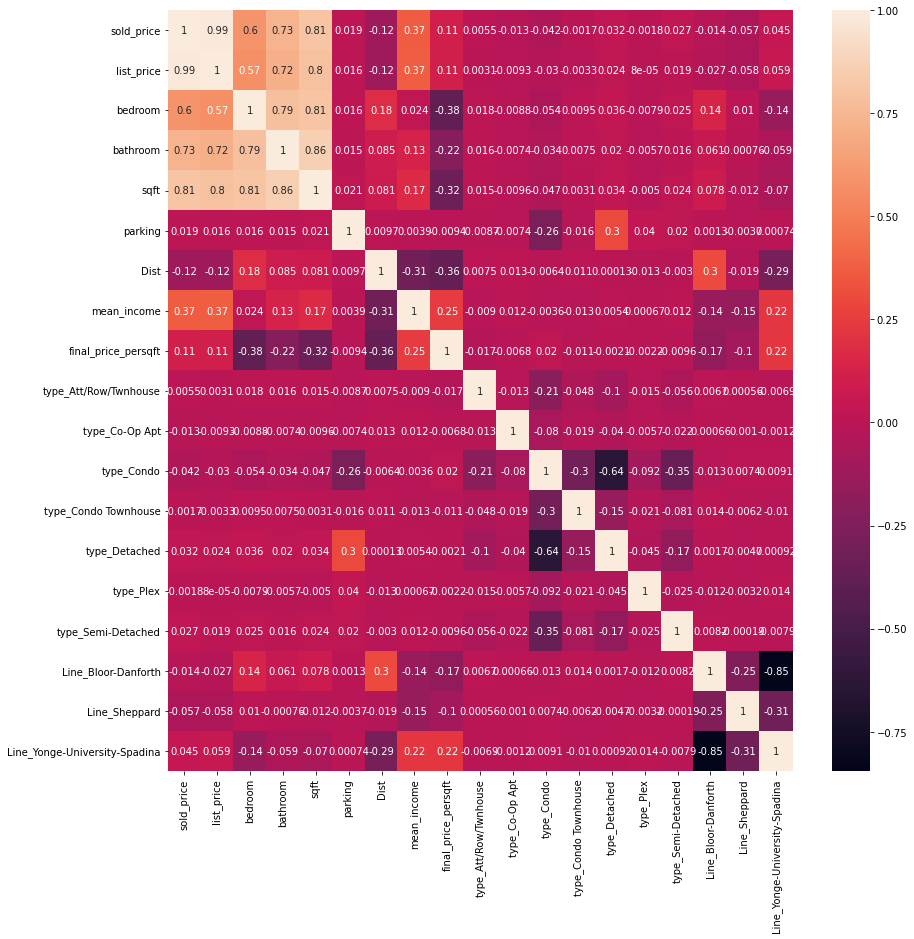

In [38]:
fig, ax = plt.subplots(figsize=[14, 14])
ax = sns.heatmap(d.corr(), annot=True)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


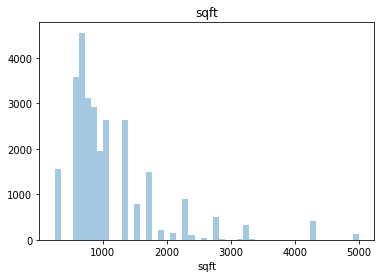

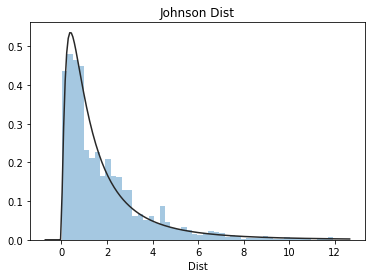

In [39]:
plt.figure(1); plt.title('sqft')
sns.distplot(d['sqft'], kde=False)


plt.figure(2); plt.title('Johnson Dist')
sns.distplot(d['Dist'], kde=False, fit=stats.johnsonsu)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

hi


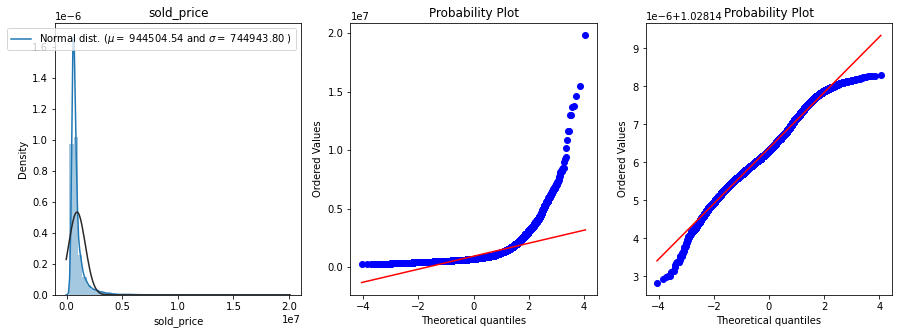

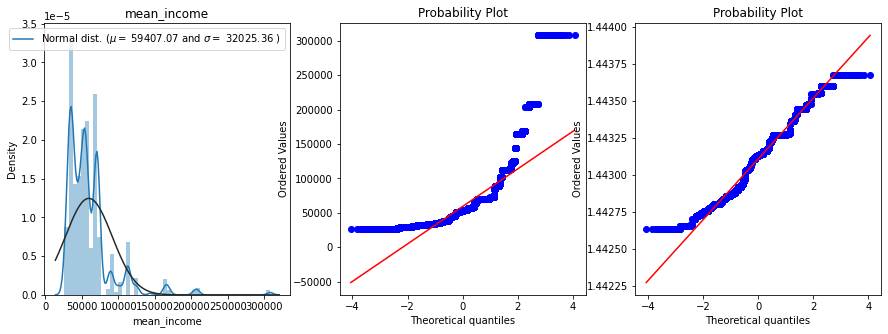

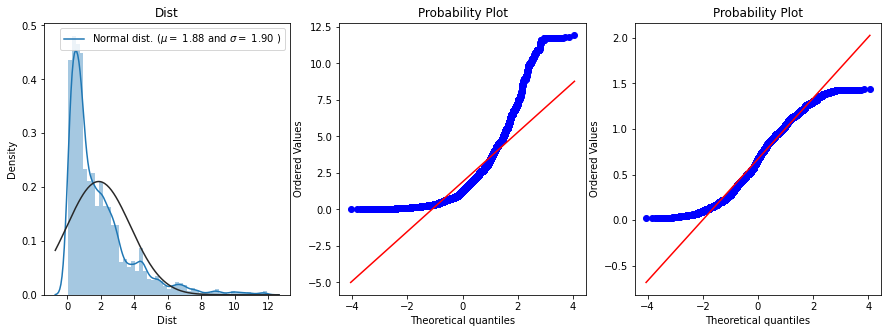

In [40]:
attributes=['sold_price', 'mean_income', 'Dist']
for attribute in attributes:
    plt.figure(figsize=(15,5))
    x = d[attribute]
    ax1=plt.subplot(1,3,1)
    plt.subplots_adjust(hspace=1)
    sns.distplot(x, fit=stats.norm)
    plt.title(attribute)
    (mu, sigma) = stats.norm.fit(x)
    plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)])

    ax2=plt.subplot(1,3,2)
    stats.probplot(x, dist=stats.norm, plot=ax2)

    ax3=plt.subplot(1,3,3)
    if attribute != 'Dist':
      boxcox_lambda = stats.boxcox_normmax(x, brack=(-2, 2.0),  method='mle')
      transformed_sp = stats.boxcox(x, boxcox_lambda)
    else:
      transformed_sp, johnson_lambdas = stats.yeojohnson(x)
      print('hi')
    stats.probplot(transformed_sp, dist=stats.norm, plot=ax3)

   

In [42]:
from sklearn.preprocessing import PowerTransformer
house_data_d_copy = d.copy()
#numerics = ['sqft', 'mean_income', 'Dist']
numerics = ['mean_income', 'Dist', 'sold_price']
lambdas=[]
pt = PowerTransformer(method='box-cox')
pt1 = PowerTransformer(method='yeo-johnson')
house_data_d_copy['sold_price'] = house_data_d_copy['sold_price']/100
house_data_d_copy['mean_income'] = house_data_d_copy['mean_income']/10

for numeric_feat in numerics:
  if numeric_feat != 'Dist':
    house_data_d_copy[[numeric_feat]] = pt.fit_transform(house_data_d_copy[[numeric_feat]])
    lambdas.append(pt.lambdas_[0])
  else:
    house_data_d_copy[[numeric_feat]] = pt1.fit_transform(house_data_d_copy[[numeric_feat]])
    lambdas.append(pt1.lambdas_[0])
print(lambdas)

[-0.6925684744874029, -0.5061318572156559, -0.9726222990680731]


In [43]:
house_data_d_copy.head(5)

,sold_price,list_price,bedroom,bathroom,sqft,parking,Dist,mean_income,final_price_persqft,type_Att/Row/Twnhouse,type_Co-Op Apt,type_Condo,type_Condo Townhouse,type_Detached,type_Plex,type_Semi-Detached,Line_Bloor-Danforth,Line_Sheppard,Line_Yonge-University-Spadina
0,-0.629356,550000.0,1,1,249.5,1.0,-1.233027,0.266566,2404.809619,0,0,1,0,0,0,0,0,0,1
1,-0.331686,599000.0,1,1,549.5,1.0,0.826096,0.173077,1201.091902,0,0,1,0,0,0,0,1,0,0
2,0.266200,699000.0,2,1,749.5,1.0,-1.074170,0.057677,1100.733823,0,0,1,0,0,0,0,0,1,0
3,0.490591,869000.0,2,2,849.5,1.0,-1.164223,-0.007445,1071.218364,0,0,1,0,0,0,0,0,0,1
4,-0.377533,499000.0,1,1,649.5,1.0,0.255176,-0.999949,1000.769823,0,0,1,0,0,0,0,0,1,0


In [44]:
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error

house_data_d_copy[predictors] = house_data_d_copy[predictors].astype(float)
house_data_d_copy.sold_price =  house_data_d_copy.sold_price.astype(float)


X_train, X_test, y_train, y_test = train_test_split(house_data_d_copy[predictors], 
                                                    house_data_d_copy.sold_price, test_size = 0.3, 
                                                    random_state=33, stratify=house_data_d_copy["type_Condo"].values)
cv_split= KFold(n_splits=10, shuffle=True, random_state=1)

In [45]:
import xgboost as xgb
clf2 = xgb.XGBRegressor(objective='reg:squarederror', seed=33)
clf2.fit(X_train, y_train)
yhat2 = clf2.predict(X_test)

y_test2 = pt.inverse_transform(pd.DataFrame(y_test, columns=['sold_price'])) * 100
y_pred2 = pt.inverse_transform(pd.DataFrame(yhat2,columns=['sold_price']))  * 100
print(mean_absolute_error(y_test2, y_pred2))
print(np.sqrt(mean_squared_error(y_test2, y_pred2)))

144262.09646643003
330372.26156760624


In [46]:
clf2.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'importance_type': 'gain',
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'reg:squarederror',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': 33,
 'silent': None,
 'subsample': 1,
 'verbosity': 1}

In [47]:
X_train1, X_validation1, y_train1, y_validation1 = train_test_split(X_train, y_train, test_size=0.25)
dtrain = xgb.DMatrix(data=X_train1, label=y_train1)

In [66]:
import hyperopt.pyll
from hyperopt.pyll import scope
space1 = hp.uniform('a', 0, 10)
print(space1['a'])

0 getitem
1   float
2     hyperopt_param
3       Literal{a}
4       uniform
5         Literal{0}
6         Literal{10}
7   Literal{a}


In [67]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
space={'max_depth':  hp.uniform('max_depth', 1, 12),
       'learning_rate': hp.uniform('learning_rate', 0.01,0.1),
       'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
        'gamma': hp.uniform ('gamma', 0,9),
        'reg_alpha' : hp.quniform('reg_alpha', 0,150,10),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : 1, #hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': hp.quniform('n_estimators', 100, 500, 50),
        'nthread': 4,
        'seed': 33
    }
def objective(space):
    clf=xgb.XGBRegressor(
                    objective ='reg:squarederror',learning_rate=space['learning_rate'],
                    n_estimators =int(space['n_estimators']), max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = space['reg_alpha'], reg_lambda = space['reg_lambda'], min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']), subsample=space['subsample'])
    
    evaluation = [( X_train1, y_train1), (X_validation1, y_validation1)]
    #dtrain = xgb.DMatrix(data=X_train1, label=y_train1)
    #dvalid = xgb.DMatrix(data=X_validation1, label=y_validation1)
    #watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
#    clf.fit(X_train, y_train,eval_set=evaluation, eval_metric='rmse',early_stopping_rounds=10,verbose=False)
    clf.fit(X_train1, y_train1,eval_set=evaluation, eval_metric='rmse',
            early_stopping_rounds=10,verbose=True)

    pred = clf.predict(X_validation1)

    accuracy = mean_squared_error(y_validation1, pred)

    print ("SCORE:", accuracy)
    return {'loss': accuracy, 'status': STATUS_OK }

In [68]:
t = Trials()

best_hyperparams = fmin(fn = objective, space = space,
                        algo = tpe.suggest,max_evals = 200,trials = t)

Streaming output truncated to the last 5000 lines.
[86]	validation_0-rmse:0.609827	validation_1-rmse:0.607413

[87]	validation_0-rmse:0.606747	validation_1-rmse:0.60444

[88]	validation_0-rmse:0.603772	validation_1-rmse:0.601614

[89]	validation_0-rmse:0.600748	validation_1-rmse:0.59874

[90]	validation_0-rmse:0.597794	validation_1-rmse:0.595882

[91]	validation_0-rmse:0.594866	validation_1-rmse:0.593095

[92]	validation_0-rmse:0.591942	validation_1-rmse:0.590298

[93]	validation_0-rmse:0.589133	validation_1-rmse:0.587635

[94]	validation_0-rmse:0.586341	validation_1-rmse:0.584925

[95]	validation_0-rmse:0.583577	validation_1-rmse:0.582245

[96]	validation_0-rmse:0.580856	validation_1-rmse:0.579658

[97]	validation_0-rmse:0.578172	validation_1-rmse:0.577133

[98]	validation_0-rmse:0.575539	validation_1-rmse:0.574616

[99]	validation_0-rmse:0.573015	validation_1-rmse:0.572159

[100]	validation_0-rmse:0.570501	validation_1-rmse:0.569791

[101]	validation_0-rmse:0.567953	validation_1-rmse

In [69]:
print(best_hyperparams)

{'gamma': 0.20729803367782723, 'learning_rate': 0.07130086311187595, 'max_depth': 9.211489756203525, 'min_child_weight': 6.0, 'n_estimators': 300.0, 'reg_alpha': 0.0, 'reg_lambda': 0.24569783894844915, 'subsample': 0.7000000000000001}


{'gamma': 0.20729803367782723, 'learning_rate': 0.07130086311187595, 'max_depth': 9.211489756203525, 'min_child_weight': 6.0, 'n_estimators': 300.0, 'reg_alpha': 0.0, 'reg_lambda': 0.24569783894844915, 'subsample': 0.7000000000000001}

In [70]:
clf21 = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=300, learning_rate = 0.07130086311187595,
                         max_depth=9, gamma=0.20729803367782723, reg_lambda= 0.24569783894844915,
                         reg_alpha=0, min_child_weight=6, colsample_bytree=1, subsample=0.7)
#0.08676238917490152
#clf21 = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=500, learning_rate = 0.10013642773246478,
                         #max_depth=9, gamma=8.370004832886828, reg_lambda= 0.8186408519778837,
                         #reg_alpha=90, min_child_weight=8, colsample_bytree=0.5973212942576718, subsample=0.7)
#0.2180151843695646

#clf21 = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=500, learning_rate = 0.05237294372499705,
                         #max_depth=7, gamma=0.02276270423454086, reg_lambda= 0,
                         #reg_alpha=0, min_child_weight=4, colsample_bytree=0.5973212942576718, subsample=0.75)
#0.08920955079232559

clf21.fit(X_train, y_train)
yh21 = clf21.predict(X_test)
print(mean_squared_error(y_test, yh21))


0.08676238917490152


In [71]:
yh21[yh21 > 5] = 5
y_actual = pt.inverse_transform(pd.DataFrame(y_test, columns=['sold_price'])) * 100
yh21_actual = pt.inverse_transform(pd.DataFrame(yh21,columns=['sold_price']))  * 100
print(mean_absolute_error(y_actual, yh21_actual))
print(np.sqrt(mean_squared_error(y_actual, yh21_actual)))


112730.37588690584
280163.4479532585


Text(0, 0.5, 'Predicted Value')

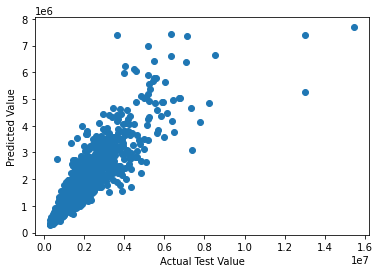

In [81]:
plt.scatter(y_actual, yh21_actual)
plt.xlabel('Actual Test Value')
plt.ylabel('Predicted Value')